# PPO for RL4CO

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from rl4co.envs import TSPEnv
from rl4co.utils.lightning import get_lightning_device
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset
# from rl4co.models import AttentionModel, AttentionModelPolicy # in this notebook, we make them from scratch.uncomment this line if you want to use the original ones.
from rl4co.models.nn.env_embedding import env_init_embedding
from rl4co.models.nn.graph import GraphAttentionEncoder
from rl4co.models.zoo.am.decoder import Decoder
from rl4co.models.nn.utils import get_log_likelihood
from rl4co.utils.pylogger import get_pylogger
from rl4co.models.nn.attention import LogitAttention
from rl4co.models.nn.env_context import env_context
from rl4co.models.nn.env_embedding import env_dynamic_embedding
from rl4co.models.nn.utils import decode_probs
from rl4co.models.zoo.am import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment
We test on a simple TSP environment

In [2]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    td.set("action", actions)
    return td

In [3]:
env = TSPEnv()

td = env.reset(batch_size=[5])
td = rollout(env, td, random_policy)

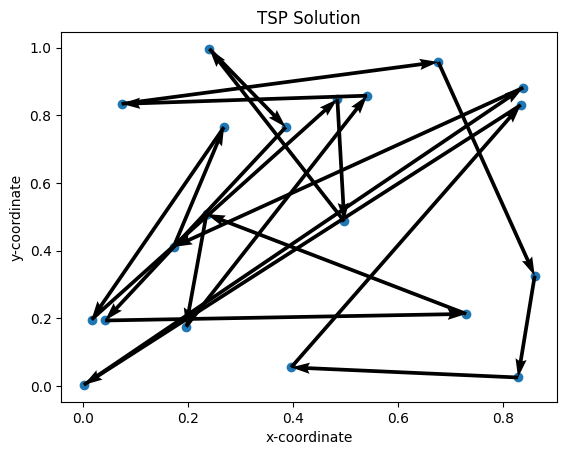

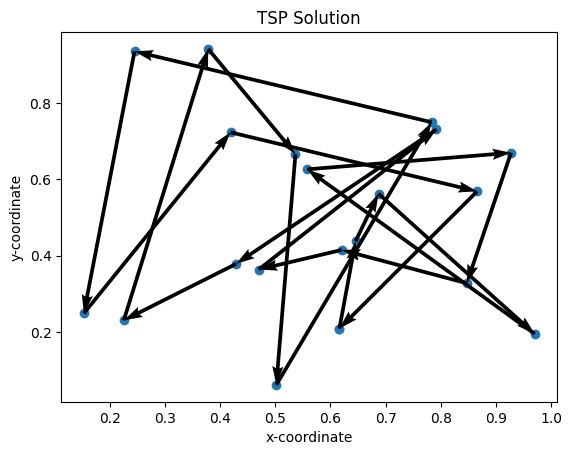

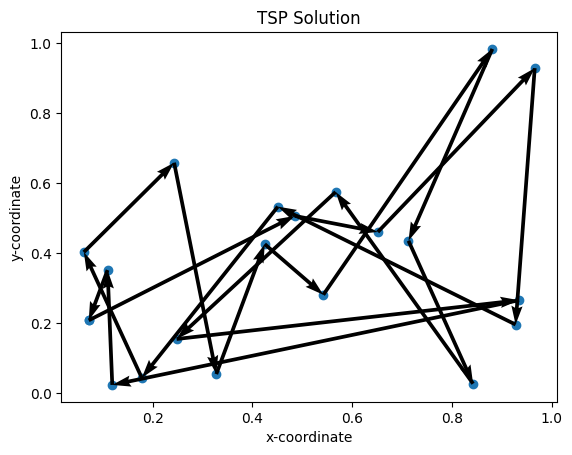

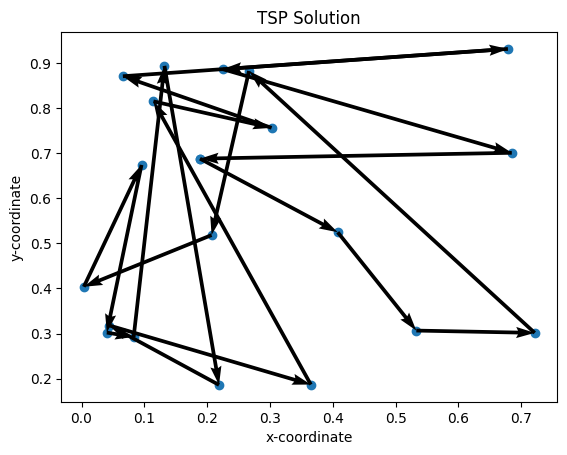

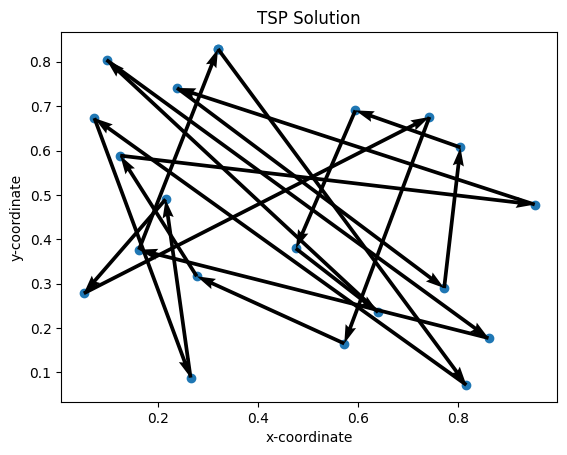

In [4]:
# Plot 
# env.render(td)
# td.set('action', actions)
for i in range(5):
    env.render(td[i])

## Test the Policy only

The policy takes an initial state and gives back collected rewards and log likelihood. We can also return extras such as actions

In [5]:
# Load environment with test data
env = TSPEnv()

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

policy = AttentionModelPolicy(
    env,
).to("cuda")

# model = torch.compile(model)

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling", return_actions=False)

print(out)

{'reward': tensor([ -9.5529,  -9.0265,  -9.1824,  -8.7701,  -9.8616,  -8.5389,  -7.2103,
        -10.5495,  -9.3380,  -7.6965,  -8.4791,  -9.0243,  -9.7055,  -9.6136,
        -10.4523,  -9.3170,  -9.4114, -11.7332,  -8.0750, -11.3366,  -9.3084,
         -9.4495,  -8.2690,  -8.2387,  -7.9766, -10.1325,  -9.8229,  -8.1991,
         -7.7694, -10.4945, -10.2205,  -8.4165,  -8.6603,  -9.1003, -11.3450,
         -7.9412,  -9.9529,  -9.6515,  -9.5274, -12.0830, -10.2027,  -8.6033,
         -8.9033,  -9.4639,  -8.4524,  -8.7166, -10.3876,  -6.8718,  -9.5995,
        -11.0617,  -8.8363, -10.2440,  -8.9670,  -9.0377, -10.2864, -10.4192,
         -9.4826, -10.7654,  -8.6549,  -9.2246,  -9.6447,  -7.3394, -10.9112,
        -10.2488], device='cuda:0'), 'log_likelihood': tensor([-33.9095, -39.8787, -35.9310, -34.0118, -39.0454, -38.5883, -36.8273,
        -39.1336, -40.5313, -37.4145, -37.2476, -37.0837, -37.0175, -42.1992,
        -39.3076, -39.1690, -41.0011, -39.4242, -37.0488, -42.0262, -40.5544

## PPO

The clipped importance weighted loss is computed as follows:

loss = -min( weight * advantage, min(max(weight, 1-eps), 1+eps) * advantage)

In [9]:
import torch.nn.functional as F
import torch.distributions as D
from rl4co.data.dataset import ExtraKeyDataset
from rl4co.data.dataset import tensordict_collate_fn


class PPO(nn.Module):
    """Clipped PPO module
    
    loss = -min( weight * advantage, min(max(weight, 1-eps), 1+eps) * advantage)
    """
    def __init__(self, 
                 env, 
                 actor, 
                 critic,
                 clip_epsilon=0.2,
                 critic_coef=1.0,
                 entropy_coef=0.01,
                 entropy_bonus=True,
                 normalize_advantage=True,
                 loss_critic=F.smooth_l1_loss,
                 ):

        super(PPO, self).__init__()
        self.env = env
        self.actor = actor
        self.critic = critic

        # Parameters
        self.clip_epsilon = clip_epsilon
        self.critic_coef = critic_coef
        self.entropy_coef = entropy_coef
        self.entropy_bonus = entropy_bonus
        self.normalize_advantage = normalize_advantage
        self.loss_critic = self._loss_critic(loss_critic)
      
    @property
    def _clip_bounds(self):
        return (
            math.log1p(-self.clip_epsilon),
            math.log1p(self.clip_epsilon),
        )
    
    def forward(self, td: TensorDict,  phase: str = "train",  extra=None, **actor_kwargs):
        # Evaluate model, get costs and log probabilities
        td_out = self.actor(td, phase, **actor_kwargs)

        # NOTE: take extra key for calculating old logprobs, rewards etc
        if phase == "train":
            # Calculate advantages compared to critic estimate
            assert isinstance(extra, TensorDict), "extra needs to be a TensorDict contain additional data for PPO training"
            td_old = extra

            advantage = td_out["reward"] - td_old["state_value"]

            # Normalize advantage (PPO2)
            if self.normalize_advantage and advantage.numel() > 1:
                loc = advantage.mean().item()
                scale = advantage.std().clamp_min(1e-6).item()
                advantage = (advantage - loc) / scale

            log_weight, dist = self._log_weight(td)

            if not advantage.shape == log_weight.shape:
                raise RuntimeError(
                    f"advantage.shape and log_weight.shape do not match (got {advantage.shape} "
                    f"and {log_weight.shape})"
                )
            
            # Calculate gains for clipped objective
            gain1 = log_weight.exp() * advantage
            log_weight_clipped = log_weight.clamp(*self._clip_bounds)
            gain2 = log_weight_clipped.exp() * advantage
            gain = torch.stack([gain1, gain2], dim=-1).min(dim=-1)[0]

            td_out.set("loss_objective", -gain.mean())

            if self.entropy_bonus:
                entropy = self.get_entropy_bonus(dist)
                td_out.set("entropy", entropy.mean().detach())  # for logging
                td_out.set("loss_entropy", -self.entropy_coef * entropy.mean())

            if self.critic_coef:
                loss_critic = self.loss_critic(td_out["reward"], td_old["state_value"], reduction="none")
                td_out.set("loss_critic", loss_critic.mean())

        return td_out
    
    def _log_weight(
        self, td: TensorDict
    ) -> Tuple[torch.Tensor, D.Distribution]:
        action = td.get("action")
        if action.requires_grad:
            raise RuntimeError("tensordict stored action requires grad.")

        # NOTE: todo inside actor
        dist = self.actor.get_dist(td)
        log_prob = dist.log_prob(action)

        prev_log_prob = td.get("sample_log_prob")
        if prev_log_prob.requires_grad:
            raise RuntimeError("tensordict prev_log_prob requires grad.")

        log_weight = (log_prob - prev_log_prob).unsqueeze(-1)
        return log_weight, dist
    
    def get_entropy_bonus(self, dist: D.Distribution) -> torch.Tensor:
        try:
            entropy = dist.entropy()
        except NotImplementedError:
            x = dist.rsample((self.samples_mc_entropy,))
            entropy = -dist.log_prob(x)
        return entropy.unsqueeze(-1)
    
    def wrap_dataset(self, dataset, env, batch_size=64, device="cpu", **kw):
        """This automatically generates the baseline for PPO"""
        td_out = (
            self.rollout(env, batch_size, device, dataset=dataset)
            .detach()
            .cpu()
        )
        return ExtraKeyDataset(dataset, td_out)
        
    def rollout(self, env=None, batch_size=64, device="cpu", dataset=None):
        """Rollout the model on the given dataset"""
        # if dataset is None, use the dataset of the baseline
        dataset = self.dataset if dataset is None else dataset

        model.eval()
        model = model.to(device)

        def eval_actor_critic(batch):
            with torch.no_grad():
                batch = env.reset(batch.to(device))
                # TODO: check if greedy
                td_out = self.actor(batch, decode_type="greedy").cpu()
                td_out.set("state_value", self.critic(batch).cpu())
                return td_out
            
        dl = DataLoader(
            dataset, batch_size=batch_size, collate_fn=tensordict_collate_fn
        )

        td_out = torch.cat(
            [eval_actor_critic(batch) for batch in dl], 0
        )

        return td_out

In [15]:
?? PPO

Init signature:  PPO(env, actor=None, critic=None)
Docstring:     
Clipped PPO module

loss = -min( weight * advantage, min(max(weight, 1-eps), 1+eps) * advantage)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
Type:           type
Subclasses:     

In [ ]:
    # def forward(self, tensordict: TensorDictBase) -> TensorDictBase:
    #     tensordict = tensordict.clone(False)
    #     advantage = tensordict.get(self.advantage_key, None)
    #     if advantage is None:
    #         self.value_estimator(
    #             tensordict,
    #             params=self.critic_params.detach(),
    #             target_params=self.target_critic_params,
    #         )
    #         advantage = tensordict.get(self.advantage_key)
    #     if self.normalize_advantage and advantage.numel() > 1:
    #         loc = advantage.mean().item()
    #         scale = advantage.std().clamp_min(1e-6).item()
    #         advantage = (advantage - loc) / scale

    #     log_weight, dist = self._log_weight(tensordict)
    #     # ESS for logging
    #     with torch.no_grad():
    #         # In theory, ESS should be computed on particles sampled from the same source. Here we sample according
    #         # to different, unrelated trajectories, which is not standard. Still it can give a idea of the dispersion
    #         # of the weights.
    #         lw = log_weight.squeeze()
    #         ess = (2 * lw.logsumexp(0) - (2 * lw).logsumexp(0)).exp()
    #         batch = log_weight.shape[0]

    #     if not advantage.shape == log_weight.shape:
    #         raise RuntimeError(
    #             f"advantage.shape and log_weight.shape do not match (got {advantage.shape} "
    #             f"and {log_weight.shape})"
    #         )
    #     gain1 = log_weight.exp() * advantage

    #     log_weight_clip = log_weight.clamp(*self._clip_bounds)
    #     gain2 = log_weight_clip.exp() * advantage

    #     gain = torch.stack([gain1, gain2], -1).min(dim=-1)[0]
    #     td_out = TensorDict({"loss_objective": -gain.mean()}, [])

    #     if self.entropy_bonus:
    #         entropy = self.get_entropy_bonus(dist)
    #         td_out.set("entropy", entropy.mean().detach())  # for logging
    #         td_out.set("loss_entropy", -self.entropy_coef * entropy.mean())
    #     if self.critic_coef:
    #         loss_critic = self.loss_critic(tensordict)
    #         td_out.set("loss_critic", loss_critic.mean())
    #     td_out.set("ESS", ess.mean() / batch)
    #     return td_out

In [8]:
class AttentionModel(REINFORCE):
    def __init__(self, env, policy=None, baseline=None):
        """
        Attention Model for neural combinatorial optimization based on REINFORCE
        Based on Wouter Kool et al. (2018) https://arxiv.org/abs/1803.08475
        Refactored from reference implementation: https://github.com/wouterkool/attention-learn-to-route

        Args:
            env: TorchRL Environment
            policy: Policy
            baseline: REINFORCE Baseline
        """
        super(AttentionModel, self).__init__(env, policy, baseline)
        self.env = env
        self.policy = AttentionModelPolicy(env) if policy is None else policy
        self.baseline = (
            WarmupBaseline(RolloutBaseline()) if baseline is None else baseline
        )

In [9]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([-11.0284,  -9.4791, -10.5583,  -9.7481, -10.5926, -10.0620, -12.6127,
        -11.1213, -11.0297, -10.2156, -10.3954, -11.4021, -12.6304, -10.5466,
        -10.2193, -10.4874, -10.2196,  -9.6671, -10.3153, -10.2223,  -9.0844,
         -8.8959, -10.8784, -12.1765, -11.2916, -12.0365,  -9.5245,  -9.9518,
         -8.8840, -10.5723,  -6.7842, -10.2328,  -9.6604, -10.3641,  -8.9470,
        -10.7006, -10.5311,  -8.4341,  -9.3277, -10.0843, -10.8541, -13.3360,
        -12.7606, -10.1583, -11.0076,  -9.2807, -10.2506, -10.4619, -10.8410,
         -9.7360, -11.6632,  -9.3827, -10.4159,  -8.7398, -10.6774, -10.6485,
         -9.4084,  -8.1385,  -9.9130, -11.0512, -12.5891, -10.6200,  -8.8675,
         -9.2862], device='cuda:0'), 'log_likelihood': tensor([-35.7632, -38.5826, -41.2519, -40.1952, -41.5424, -43.0650, -38.2575,
        -37.6977, -40.6805, -40.4287, -39.9030, -39.1823, -34.5732, -37.8878,
        -35.3816, -40.6912, -40.9587, -42.5525, -36.2357, -36.7524, -38.9009

## Lightning Module

We can simply import this from RL4CO, no need to reinvent the wheel!


In [10]:
from rl4co.tasks.rl4co import RL4COLitModule
# ?? RL4COLitModule

## Main training setup

In [11]:

config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "train_batch_size": 512,
            "val_batch_size": 1024,
        },
        "optimizer": {
            "_target_": "torch.optim.Adam",
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)

lit_module = RL4COLitModule(config, env, model)

## Fit model

In [12]:
# Set debugging level as info to see all message printouts
import logging
logging.basicConfig(level=logging.INFO)

# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=3, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:rl4co.tasks.rl4co:Setting up datasets
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:rl4co.tasks.rl4co:No optimizer specified, using default
INFO:rl4co.tasks.rl4co:Instantiating optimizer <torch.optim.Adam>

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TSPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
2023-05-18 16:28:49.170771: I tensorflow/core/util/port.cc:110] oneDNN custom operations a

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 33.12it/s, v_num=18, train/reward=-4.28, train/loss=-.370, val/reward=-4.09]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -4.085, Baseline mean: -8.851
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Set warmup alpha = 1.0


Epoch 1: 100%|██████████| 196/196 [00:06<00:00, 31.66it/s, v_num=18, train/reward=-4.04, train/loss=-.516, val/reward=-4.02]   

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -4.022, Baseline mean: -4.086
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 2: 100%|██████████| 196/196 [00:06<00:00, 31.31it/s, v_num=18, train/reward=-4.08, train/loss=-.225, val/reward=-4.01] 

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -4.006, Baseline mean: -4.021
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s, v_num=18, train/reward=-4.08, train/loss=-.225, val/reward=-4.01]


In [13]:
trainer.test(lit_module)

INFO:rl4co.tasks.rl4co:Setting up datasets
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 71.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -4.006200790405273     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -4.006200790405273}]

## Analyze results

In [14]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy", return_actions=True)
out['reward'].mean()

tensor(-4.0391, device='cuda:0')

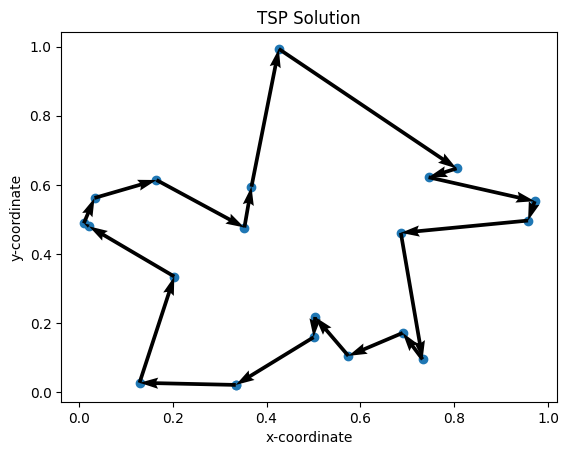

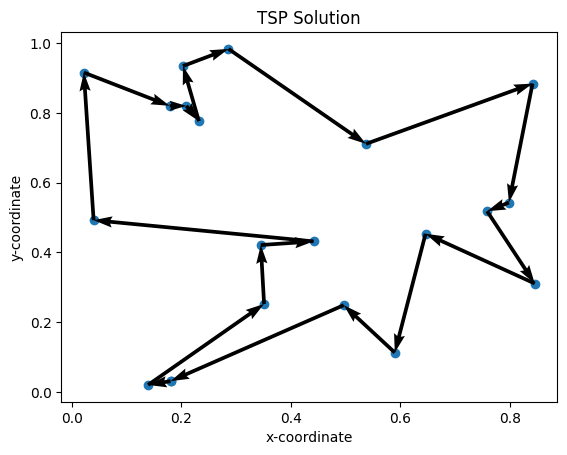

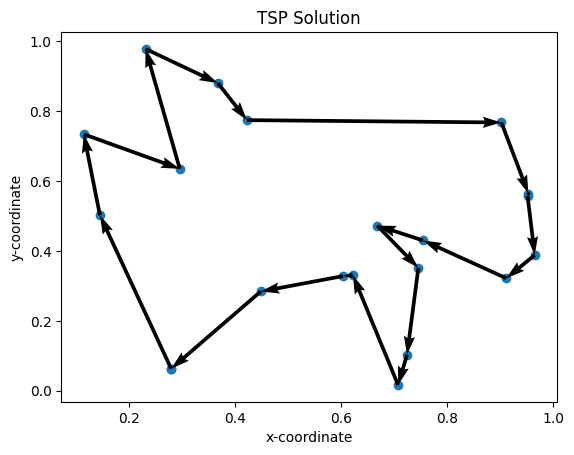

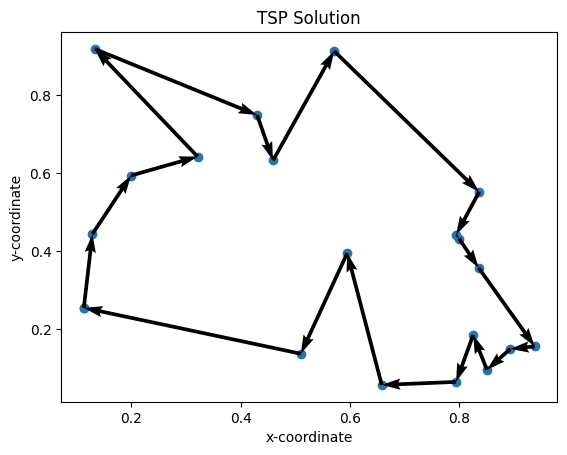

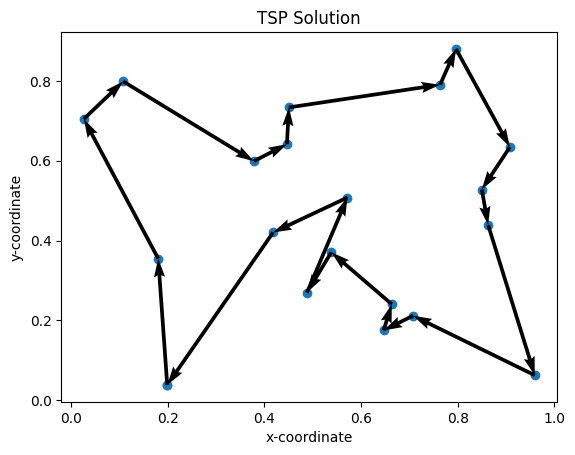

In [16]:
td.set('reward', out['reward'])
td.set('action', out['actions'])
for i in range(5):
    env.render(td[i])